In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from itertools import product
import pickle
from functools import partial

In [45]:
def inv_fisher(series, counts_only):
    stacked = np.stack(series.values, axis=0)
    if counts_only:
        stacked = np.delete(stacked, 5, axis=1)
        stacked = np.delete(stacked, 5, axis=2)
    inv = np.linalg.inv(stacked)
    return inv

def cramer_rao_std(series):    
    cr = np.diag(np.sqrt(np.average(series, axis=0)))
    return cr


def read_data(fname):
    
    counts_only = "counts_only" in fname

    df = pd.DataFrame(pickle.load(open(fname, "rb")))

    if counts_only:
        varnames = ["x", "y", "z", "theta", "phi", "logE"]
    else:
        varnames = ["x", "y", "z", "theta", "phi", "t", "logE"]
       
    iff = partial(inv_fisher, counts_only=counts_only)

    cr = df.groupby(["spacing", "energy", "pmts"]).fisher.agg(iff).agg(cramer_rao_std)
    stacked = np.vstack(cr.values)
    cr_df = pd.DataFrame({varnames[i]: stacked[:, i] for i in range(len(varnames))}, index=cr.index)
    cr_df["theta_deg"] = np.degrees(cr_df["theta"])
    cr_df["phi_deg"] = np.degrees(cr_df["phi"])

    cr_df["ang_res"] = np.degrees(np.sqrt(cr_df["phi"]**2 + cr_df["theta"]**2))

    return cr_df

data_map = {
    "Full": "combined_fisher_full.pickle",
    "Counts only": "combined_fisher_counts_only.pickle",
    "MPE": "combined_fisher_tfirst.pickle"
}

dfs = {key: read_data(fname) for key, fname in data_map.items() }

dfs = pd.concat(dfs)





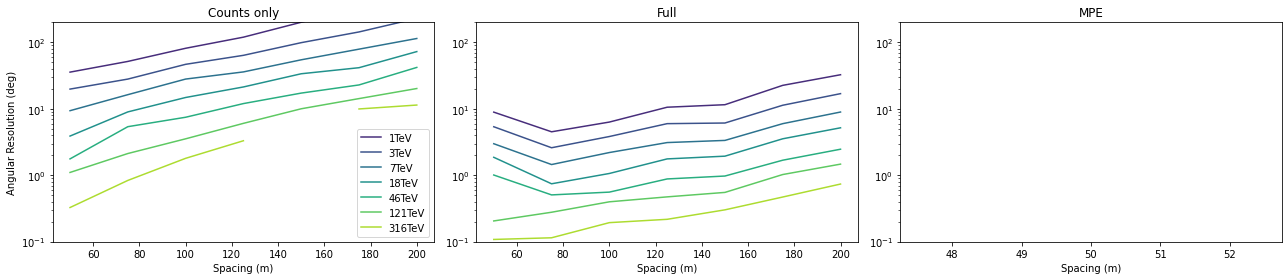

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(3*6, 4))

dfssel = dfs.loc[(slice(None), slice(None), slice(None), 24)]

energies =  np.unique(dfs.index.get_level_values(2))
colormap = sns.color_palette("viridis", len(energies))

linestyles = ["--", "-.", "-"]


for i, (energy, group) in enumerate(dfssel.groupby(level=2)):   
    for ax, (mode, group2) in zip(axs, group.groupby(level=0)): 
        ax.plot(group2.index.get_level_values(1), group2.ang_res, color=colormap[i])
        ax.set_yscale("log")
        ax.set_xlabel("Spacing (m)")
        ax.set_ylim(0.1, 200)
        ax.set_title(mode)
axs[0].set_ylabel("Angular Resolution (deg)")

proxies = [plt.Line2D([], [], color=colormap[i]) for i in range(len(energies))]
labels = [f"{e/1000:.0f}TeV" for e in energies]


axs[0].legend(proxies, labels, loc="lower right")
plt.tight_layout()
plt.savefig(f"figures/em_casc_edep_res_comp.png", dpi=150)

In [5]:
label_map = {
    "x": "x (m)",
    "y": "y (m)",
    "z": "z (m)", 
    "t": "t (ns)",
    "ang_res": "$\Delta\Psi$ (deg)",
    "logE": "log10(E/GeV)"
    }


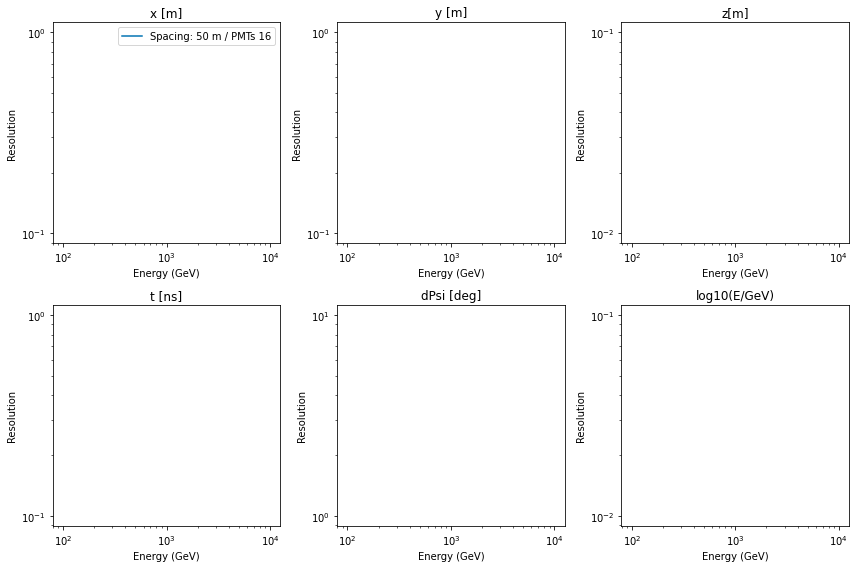

In [16]:

fig, axs = plt.subplots(2, 3, figsize=(3*4, 2*4))

grouped = cr_df.groupby(level=[0, 2])

spacings = list(cr_df.groupby(level=0).groups.keys())

colors = sns.color_palette("colorblind", len(spacings))
color_map = {spacing : colors[i] for i, spacing in enumerate(spacings)}


for pv, ax, vn in zip(plot_vars, axs.ravel(), label_names):
    for (groupn, group) in grouped:
        energies = group.index.get_level_values(1)
        if (groupn[1] != 16):
            continue

        color = color_map[groupn[0]]
         
        if groupn[1] == 16:
            ls = "-"
        else:
            ls = "--" 

        baseline = cr_df.loc[50, :, 16][pv].values

        masked = np.isfinite(group[pv])

        ax.plot(energies[masked], group[pv][masked], label=f"Spacing: {groupn[0]:.0f} m / PMTs {groupn[1]:.0f}", color=color, ls=ls)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(vn)
    ax.set_xlabel("Energy (GeV)")
    ax.set_ylabel("Resolution")
plt.tight_layout()
axs[0][0].legend()

plt.savefig(f"figures/em_casc_edep_res{plot_tag}.png", dpi=150)


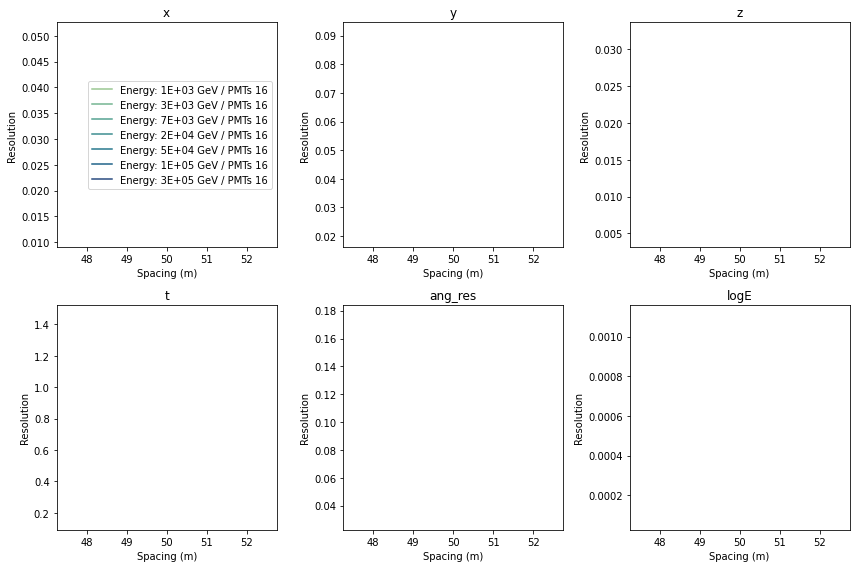

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(3*4, 2*4))

grouped = cr_df.groupby(level=[1, 2])

colors = sns.color_palette("crest", len(grouped))


for pv, ax in zip(plot_vars, axs.ravel()):
    for (groupn, group), color in zip(grouped, colors):
        spacing = group.index.get_level_values(0)
        if groupn[1] != 16:
            continue
        #baseline = cr_df.loc[50, :, 16][pv].values
        masked = np.isfinite(group[pv])
        ax.plot(spacing[masked], group[pv][masked], label=f"Energy: {groupn[0]:.0E} GeV / PMTs {groupn[1]:.0f}", color=color)
   
    ax.set_title(pv)
    ax.set_xlabel("Spacing (m)")
    ax.set_ylabel("Resolution")
axs[0][0].legend()
plt.tight_layout()
plt.savefig(f"figures/em_casc_spacingdep_res{plot_tag}.png", dpi=150)


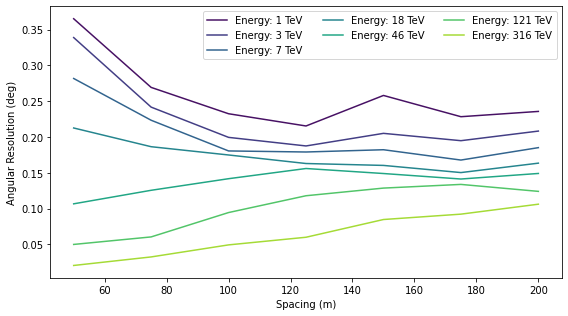

In [24]:
fig, ax = plt.subplots(figsize=(16/2, 9/2))
grouped = cr_df.groupby(level=[1, 2])

colors = sns.color_palette("viridis", len(grouped))

for (groupn, group), color in zip(grouped, colors):
    spacing = group.index.get_level_values(0)
    if groupn[1] != 16:
        continue
    #baseline = cr_df.loc[50, :, 16][pv].values
    ax.plot(spacing, group["ang_res"], label=f"Energy: {groupn[0] / 1000:.0f} TeV", color=color)
   
#ax.set_title("Angular Resolution (deg)")
ax.set_xlabel("Spacing (m)")
ax.set_ylabel("Angular Resolution (deg)")
ax.legend(ncol=3)
#axs[0][0].legend()
plt.tight_layout()
plt.savefig("figures/em_casc_spacingdep_angres.png", dpi=150)

array([  1000.        ,   2610.15721568,   6812.92069058,  17782.79410039,
        46415.88833613, 121152.76586286, 316227.76601684])

In [7]:
df["rho"] = df.position.apply(lambda s: np.sqrt(s[0]**2 + s[1]**2))
dfsel = df[(df.spacing==50) & (df.energy==np.unique(df.energy)[0]) & (df.pmts==16)]
dfsel = dfsel.set_index("rho")

varnames = ["x", "y", "z", "theta", "phi", "t", "logE"]
def inv_fisher(series):
    stacked = np.stack(series.values, axis=0)
    inv = np.linalg.inv(stacked)
    return inv

def cramer_rao_std(series):    
    cr = np.diag(np.sqrt(np.average(series, axis=0)))
    return cr

cr = dfsel.groupby(level=0).fisher.agg(inv_fisher).agg(cramer_rao_std)
stacked = np.vstack(cr.values)
cr_df = pd.DataFrame({varnames[i]: stacked[:, i] for i in range(len(varnames))}, index=cr.index)
cr_df["theta_deg"] = np.degrees(cr_df["theta"])
cr_df["phi_deg"] = np.degrees(cr_df["phi"])

cr_df["ang_res"] = np.degrees(np.sqrt(cr_df["phi"]**2 + cr_df["theta"]**2))



/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='rho', ylabel='ang_res'>

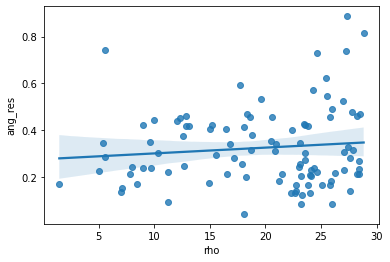

In [8]:
sns.regplot(cr_df.index, cr_df["ang_res"])

In [ ]:
varnames = ["x", "y", "z", "theta", "phi", "t", "logE"]
def inv_fisher(series):
    stacked = np.stack(series.values, axis=0)
    inv = np.linalg.inv(stacked)
    return inv

def cramer_rao_std(series):    
    cr = np.diag(np.sqrt(np.average(series, axis=0)))
    return cr

cr = df.groupby(["spacing", "energy", "pmts"]).fisher.agg(inv_fisher).agg(cramer_rao_std)
stacked = np.vstack(cr.values)
cr_df = pd.DataFrame({varnames[i]: stacked[:, i] for i in range(len(varnames))}, index=cr.index)
cr_df["theta_deg"] = np.degrees(cr_df["theta"])
cr_df["phi_deg"] = np.degrees(cr_df["phi"])

cr_df["ang_res"] = np.degrees(np.sqrt(cr_df["phi"]**2 + cr_df["theta"]**2))

